# Items and Domain Recomendations

- Using optimized parameters from another experiments
- For itens recommendations:
  - PCA components for images: **500**
  - PCA components for text: **500**
  - Parameter alpha (importance of texts): **0.8**
  - Parameter beta (importance of images): **0.2**
- For domain recommendations:
  - Number of optimal singular values k: **20** 

---

### Setup

In [91]:
# Import necessary libraries
import string
from unidecode import unidecode
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from PIL import Image
import matplotlib.pyplot as plt
import os
import session_info

In [92]:
# Display session information
session_info.show(html=False)

-----
PIL                 11.0.0
matplotlib          3.9.2
numpy               1.26.4
pandas              2.2.3
scipy               1.14.1
session_info        1.0.0
sklearn             1.5.2
unidecode           NA
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
notebook            7.2.2
-----
Python 3.12.6 (main, Sep  6 2024, 19:03:47) [Clang 15.0.0 (clang-1500.3.9.4)]
macOS-14.6.1-x86_64-i386-64bit
-----
Session information updated at 2024-11-23 12:19


In [17]:
# Parameters
ALPHA = 0.8
BETA = 1 - ALPHA
N_PCA_IMG = 500
N_PCA_TXT = 500
K_SING_VALUES = 20

In [18]:
# Function to load and flatten images
def load_and_flatten_images(df, modo_cor='rgb', img_size=(64, 64)):
    imagens = []
    ids = []
    for idx, row in df.iterrows():
        img_path = row['thumbnail_path']
        try:
            # Open the image from the specified path
            img = Image.open(img_path)
            # Resize the image to a standard size
            img = img.resize(img_size)
            if modo_cor == 'grayscale':
                # Convert the image to grayscale
                img = img.convert('L')
                # Convert the image to a numpy array and flatten it
                img_array = np.array(img).flatten()
            else:
                # Ensure the image is in RGB mode
                img = img.convert('RGB')
                # Convert the image to a numpy array and flatten it
                img_array = np.array(img).flatten()
            # Add the image array to the list
            imagens.append(img_array)
            # Store the corresponding item_id
            ids.append(row['item_id'])
        except Exception as e:
            # Print error message if image cannot be loaded
            print(f"Error loading image {img_path}: {e}")
            continue
    # Return the numpy array of images and the list of ids
    return np.array(imagens), ids

In [19]:
# Function to clean and standardize text data
def clean_text(text: str) -> str:
    # Convert text to lowercase
    text = text.lower()
    # Remove accents
    text = unidecode(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Strip whitespace
    text = text.strip()
    return text

In [68]:
# Function to plot a test item with its top-k recommendations
def plot_top_k_examples(test_idx, k=3):
    # Get the test item and its details
    test_item = test.iloc[test_idx]
    test_category = test_item['ITE_ITEM_DOM_DOMAIN_ID']
    test_image_path = test_item['thumbnail_path']
    test_title = test_item['ITE_ITEM_TITLE']

    # Compute cosine similarity for images and texts
    cos_sim_img = cosine_similarity(test_images_pca[test_idx].reshape(1, -1), train_images_pca)
    cos_sim_text = cosine_similarity(tf_idf_test_pca[test_idx].reshape(1, -1), tf_idf_train_pca)
    
    # Compute indices of top-k recommendations
    sim_scores = (ALPHA * cos_sim_text) + (BETA * cos_sim_img)
    top_k_indices = np.argpartition(np.squeeze(sim_scores), -k)[-k:].tolist()

    # Create a subplot for the test item and recommendations
    fig, axs = plt.subplots(1, k+1, figsize=(25, 6))

    # Plot the test item
    axs[0].imshow(plt.imread(test_image_path))
    axs[0].set_title(f"Test Item\nCategory: {test_category}\nTitle: {test_title}", fontsize=10)
    axs[0].axis('off')

    # Plot the top-k recommendations
    for i, idx in enumerate(top_k_indices):
        recommended_item = train.iloc[idx]
        recommended_category = recommended_item['ITE_ITEM_DOM_DOMAIN_ID']
        recommended_image_path = recommended_item['thumbnail_path']
        recommended_title = recommended_item['ITE_ITEM_TITLE']

        axs[i+1].imshow(plt.imread(recommended_image_path))
        axs[i+1].set_title(f"Rec {i+1}\nCategory: {recommended_category}\nTitle: {recommended_title}", fontsize=10)
        axs[i+1].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)
    plt.show()

In [135]:
def get_domains_recommendations(user_id, df_user_domain, preds_df, sample_items_meli_mod, n_items_per_domain = 3, print_results = True):
    """ 
    For a given user ID and the reconstructed ratings matrix returns 'n_items_per_domain' items from each
    recommended domain to the user

    The recommended domains are the ones with big residual values after the rating matrix reconstruction (excluding the
    domains which the user already have orders)
    """
    # Get User shop historic
    sorted_user_predictions = preds_df.iloc[preds_df[df_user_domain.index == user_id].index[0]].sort_values(ascending=False)
    user_orders = sample_items_meli_mod[sample_items_meli_mod.buyer_ID == (user_id)]
    # Get predictions
    recommendations = sorted_user_predictions.reset_index()["ITE_ITEM_DOM_DOMAIN_ID"].values
    recommendations_list = [rec for rec in recommendations if rec not in user_orders.ITE_ITEM_DOM_DOMAIN_ID.values][:3]
    # Display recommendations
    if print_results:
        print(f"User ID {user_id} orders:")
        print()
        for row in user_orders.iterrows():
            print(f"Item ID: {row[1]['item_id']} - Item Title: {row[1]['ITE_ITEM_TITLE']} - Item Domain: {row[1]['ITE_ITEM_DOM_DOMAIN_ID']}")
        print("="*120)
        print(f"User ID {user_id} recommendations:")
        print()
        for domain in recommendations_list:
            print(f"Items reccomended for domain: {domain}")
            sample_domain = sample_items_meli_mod[sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID==domain].sample(n_items_per_domain).reset_index(drop=True)
            for i in range(n_items_per_domain):
                print(f"Item ID: {sample_domain.loc[i, "item_id"]} - Title: {sample_domain.loc[i, "ITE_ITEM_TITLE"]}")
            print("-"*120)

    return user_orders, recommendations_list

---

### Load and Process Data

In [5]:
# Load the dataset
sample_items_meli = pd.read_csv('sample_items_meli.csv')

In [6]:
# Remove domains with few orders using cumulative sum (threshold = 55%)
domain_vc = sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.value_counts().reset_index()
domain_vc.loc[:, "cum_sum"] = domain_vc.loc[:, "count"].cumsum()
domain_vc["%_acum"] = domain_vc.loc[:, "cum_sum"] / domain_vc.loc[:, "count"].sum()
domains_to_keep = domain_vc[domain_vc["%_acum"] <= 0.55]["ITE_ITEM_DOM_DOMAIN_ID"].values
sample_items_meli_mod = sample_items_meli[sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.isin(domains_to_keep)].reset_index(drop=True)

In [7]:
# Remove duplicate items from the dataset
sample_items_meli_mod = sample_items_meli_mod.drop_duplicates(subset='item_id')

In [8]:
# Clean the item titles
sample_items_meli_mod.loc[:, "clean_title"] = sample_items_meli_mod.loc[:, "ITE_ITEM_TITLE"].apply(clean_text)

# Split the data into train and test sets
# Train set: pool of items to generate similar items
# Test set: pool of items to use as seen by the buyer while browsing
train, test = train_test_split(sample_items_meli_mod,
                               test_size=0.1,
                               stratify=sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID,
                               random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [9]:
# -----------------------------
# Creating Image Embeddings
# -----------------------------

### TRAIN SET
# Load and flatten images in RGB mode
train_images, _ = load_and_flatten_images(train, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standardize the image data
scaler = StandardScaler()
train_images_sc = scaler.fit_transform(train_images)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=N_PCA_IMG)
train_images_pca = pca.fit_transform(train_images_sc)

### TEST SET
# Load and flatten images in RGB mode
test_images, _ = load_and_flatten_images(test, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standardize the image data using the same scaler
test_images_sc = scaler.transform(test_images)
# Apply PCA using the same model
test_images_pca = pca.transform(test_images_sc)

In [10]:
# -----------------------------
# Creating Text Embeddings
# -----------------------------

### TRAIN SET
# Create TF-IDF vectors for the cleaned titles
text_vec = TfidfVectorizer(max_features=5000)
tf_idf_train = text_vec.fit_transform(train.clean_title)
# Apply PCA to reduce dimensionality and sparsity
pca_text = PCA(n_components=N_PCA_TXT)
tf_idf_train_pca = pca_text.fit_transform(tf_idf_train.toarray())

### TEST SET
# Create TF-IDF vectors for the cleaned titles
tf_idf_test = text_vec.transform(test.clean_title)
# Apply PCA using the same model
tf_idf_test_pca = pca_text.transform(tf_idf_test.toarray())

---

### Item-based recommendations

In [ ]:
test.sample(60)

In [96]:
ITEM_IDX_TEST = [526, 116, 54, 614, 328, 560, 109, 504]


Top-3 recommendations for Test Case 526


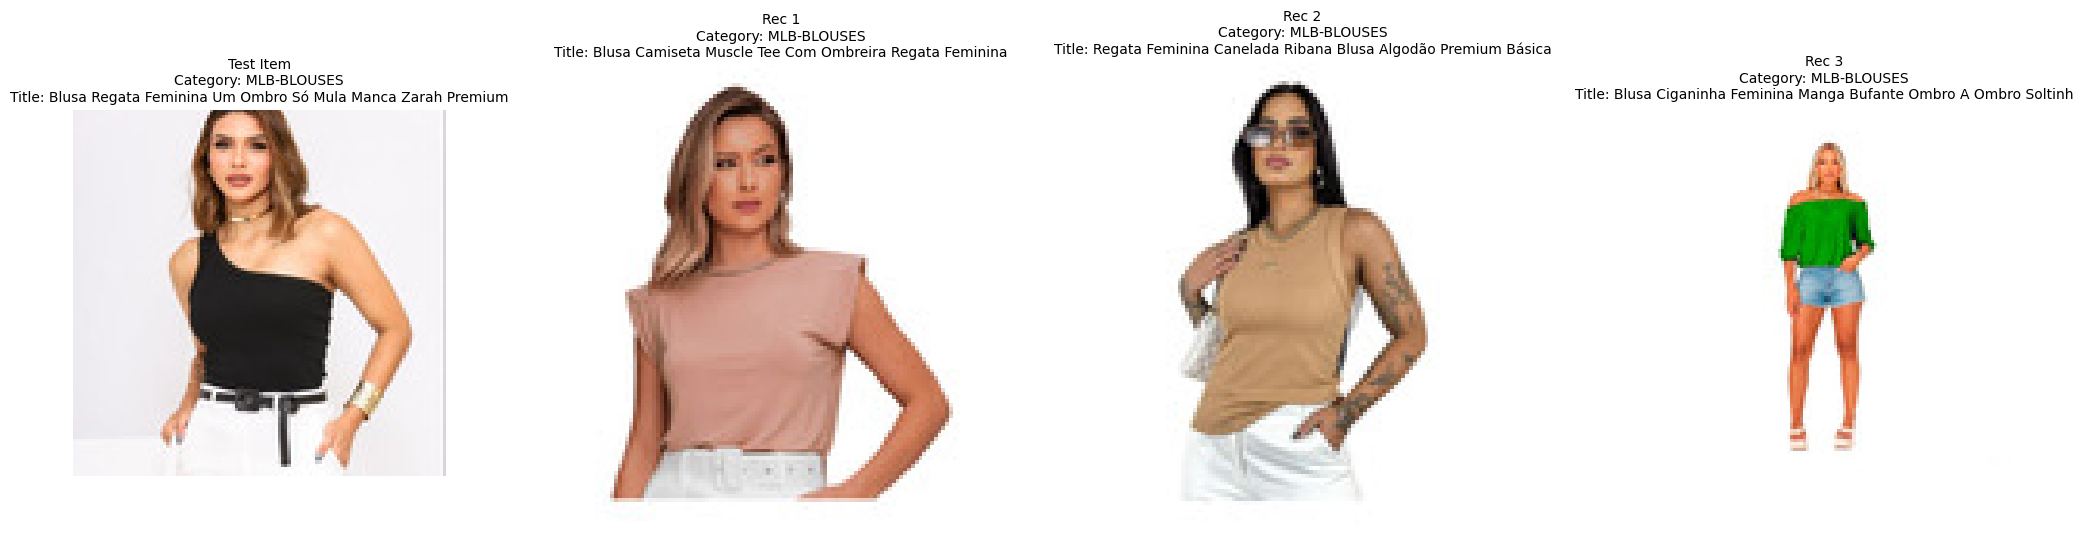


Top-3 recommendations for Test Case 116


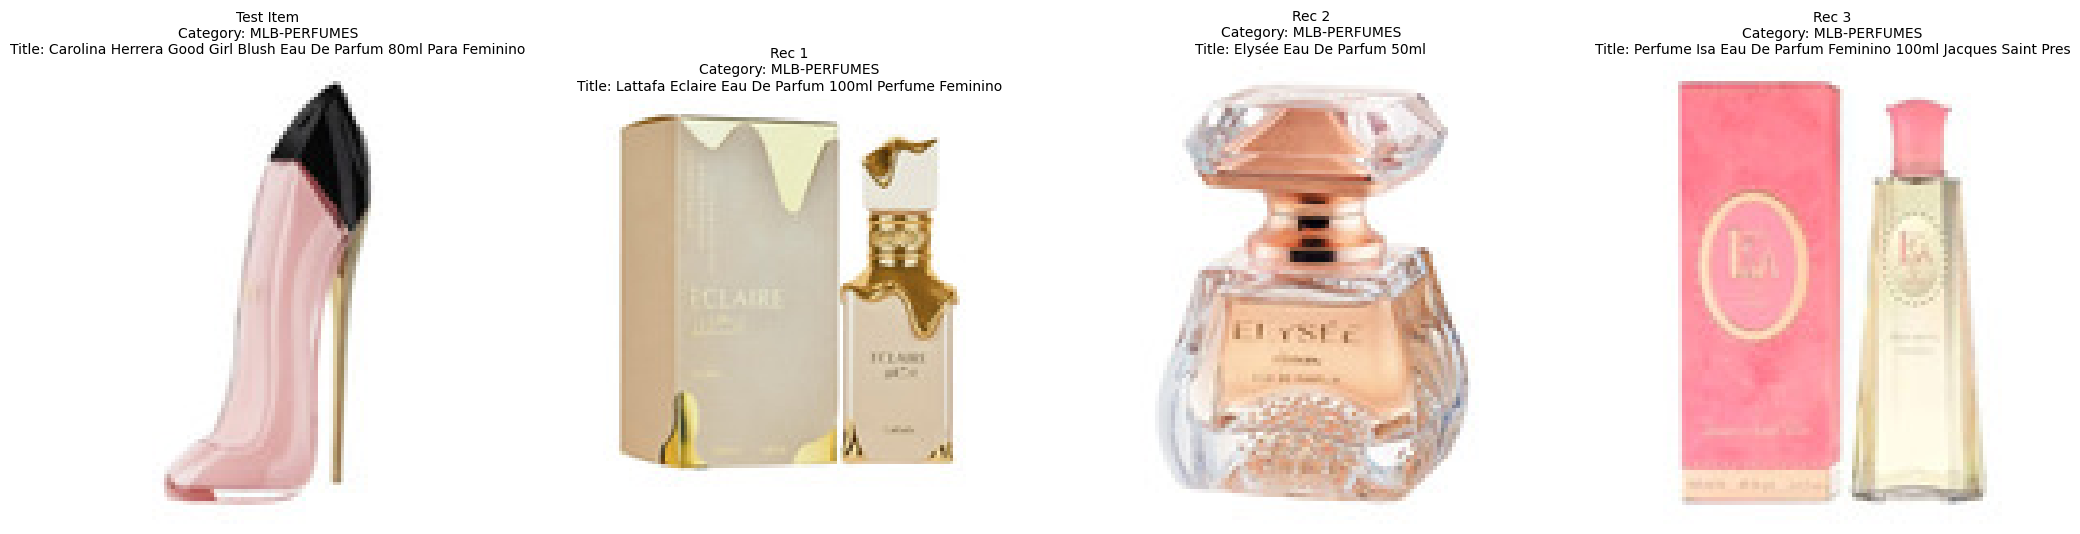


Top-3 recommendations for Test Case 54


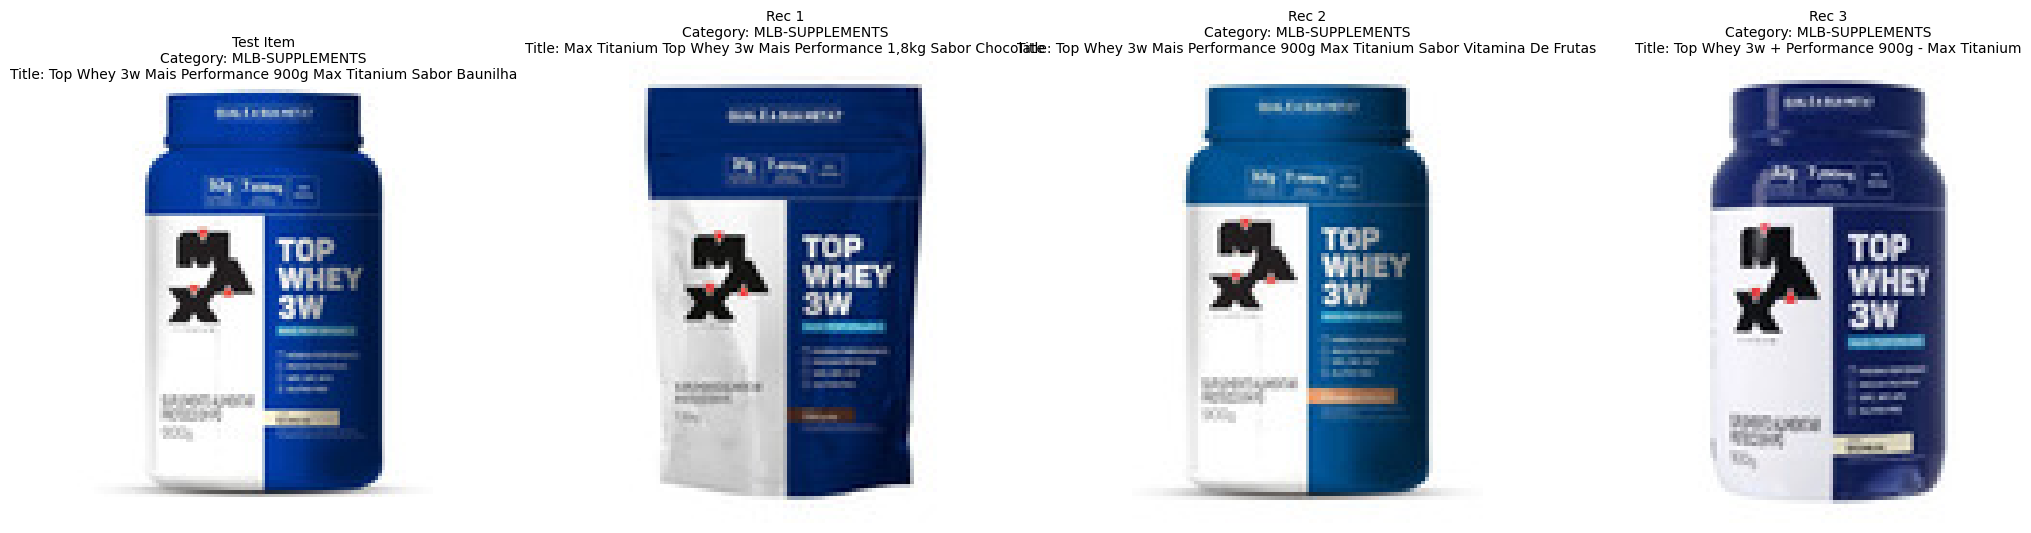


Top-3 recommendations for Test Case 614


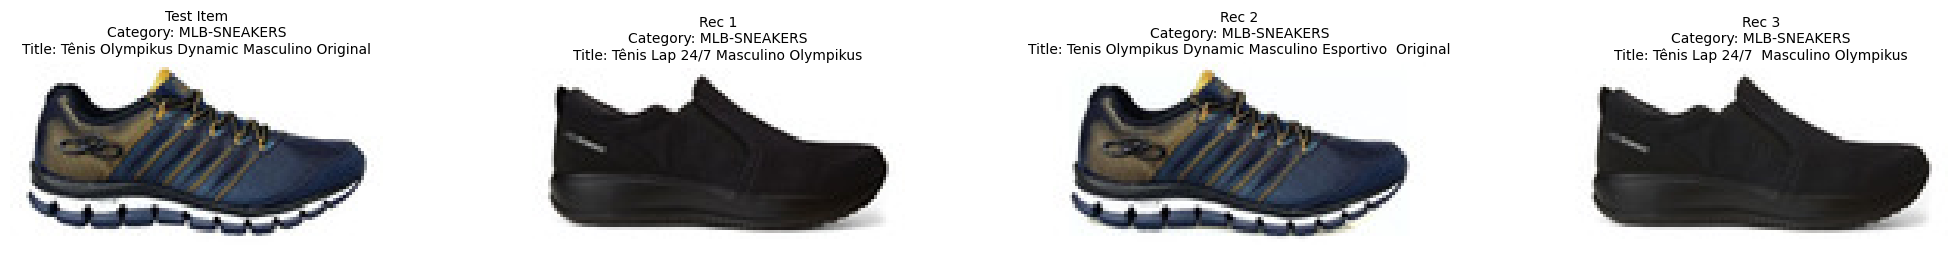


Top-3 recommendations for Test Case 328


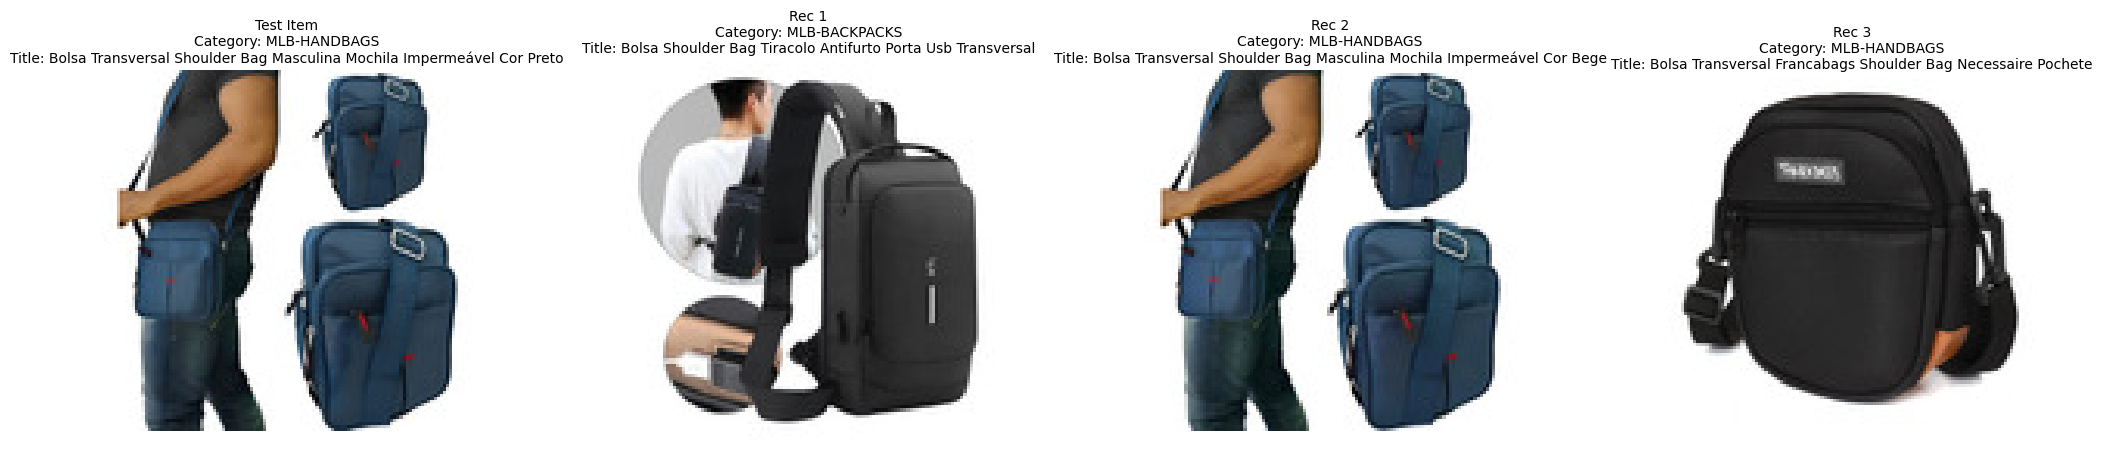


Top-3 recommendations for Test Case 560


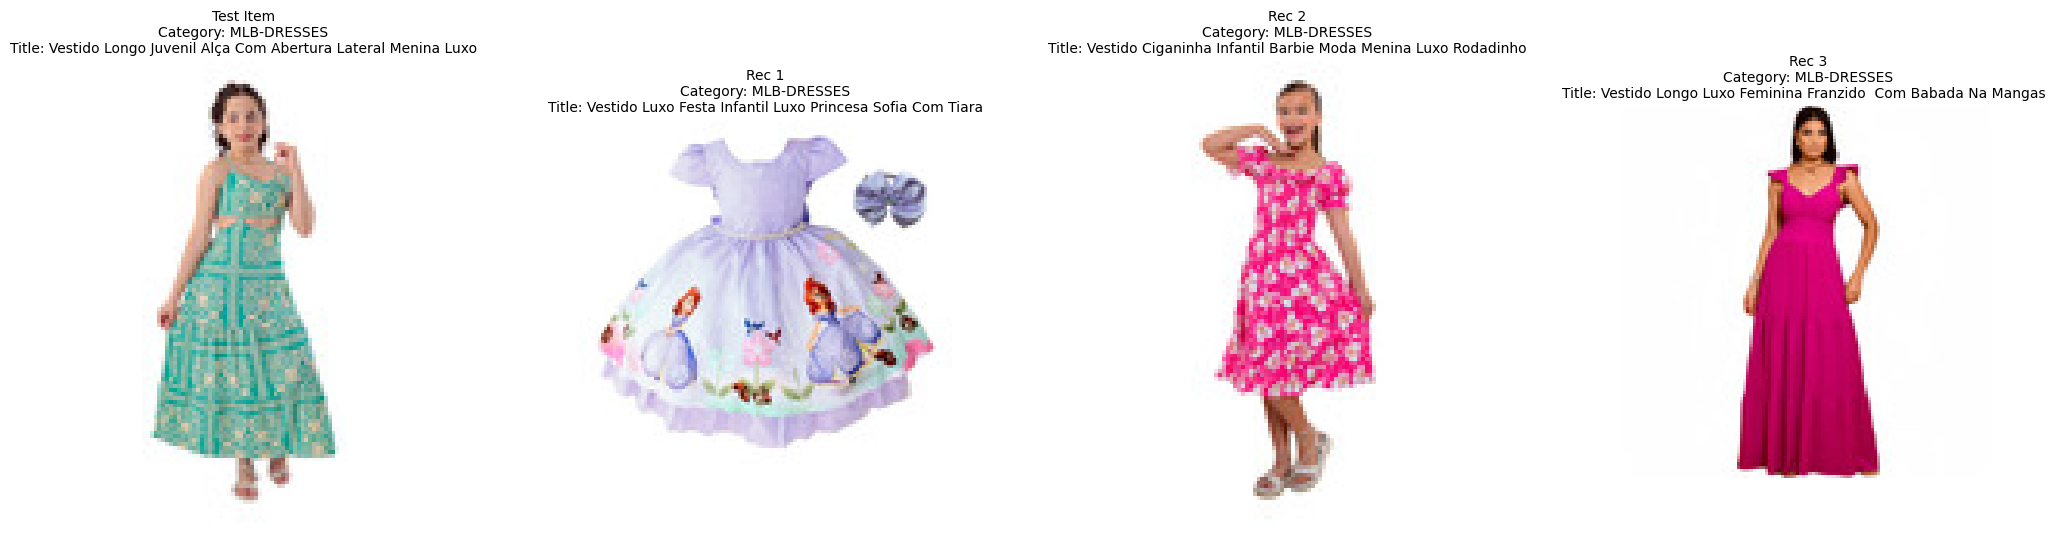


Top-3 recommendations for Test Case 109


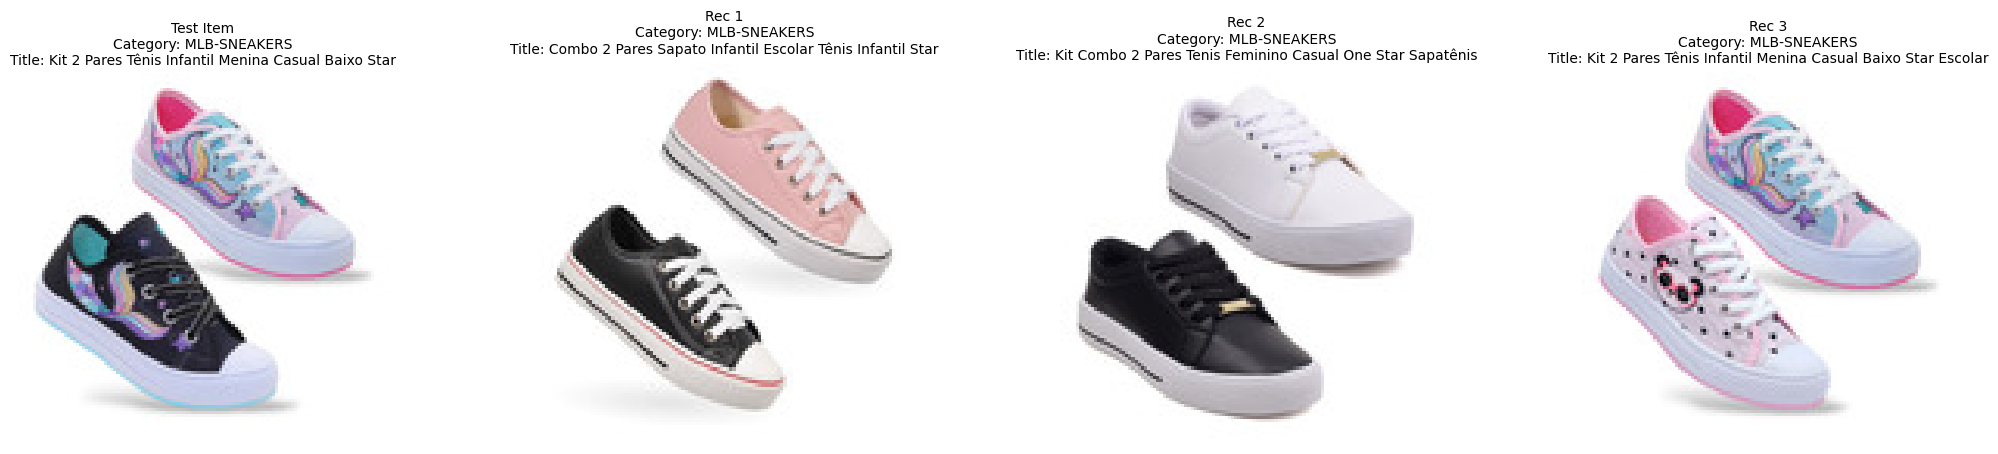


Top-3 recommendations for Test Case 504


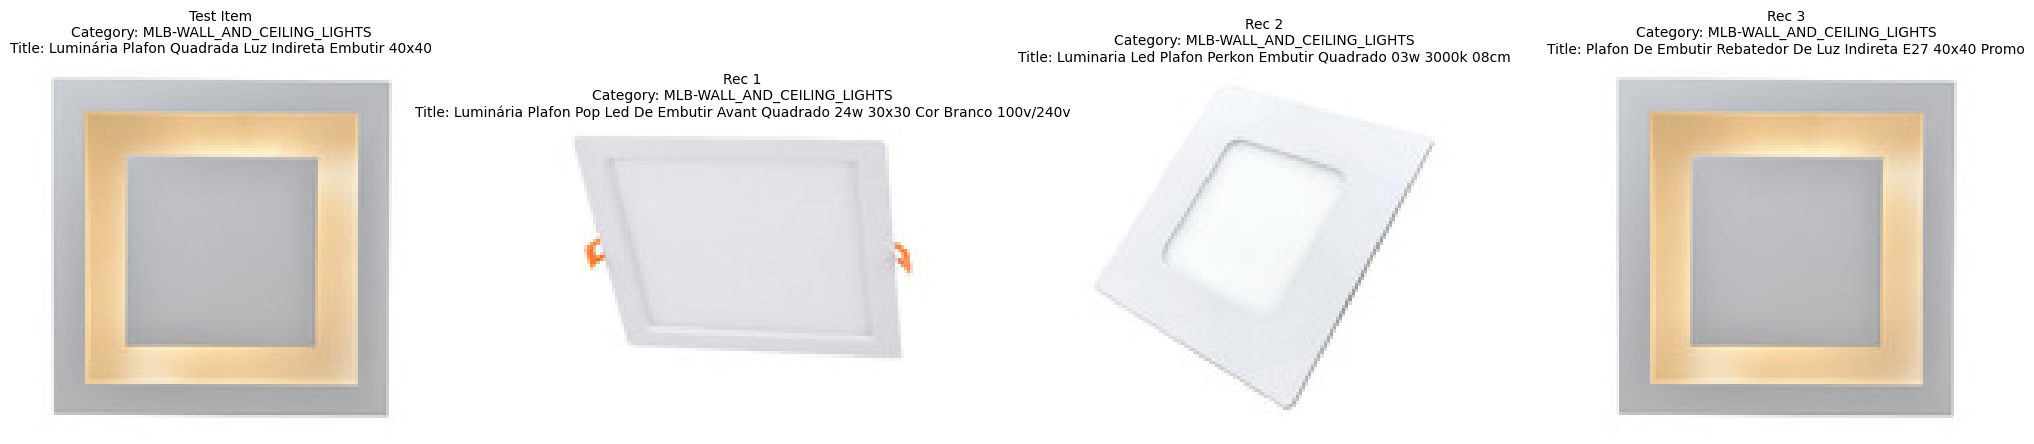

In [97]:
# Plot recommendations for specific test indices
for test_idx in ITEM_IDX_TEST:
    print(f"\nTop-3 recommendations for Test Case {test_idx}")
    plot_top_k_examples(test_idx)

---

### Domain-based recommendations

In [88]:
# Creating user ratings matrix
df_user_domain = sample_items_meli_mod.pivot_table(
    index='buyer_ID',
    columns='ITE_ITEM_DOM_DOMAIN_ID',
    aggfunc='size',
    fill_value=0
)

In [89]:
# Generate matrix to decompose
matrix_user_domain = df_user_domain.values
user_ratings_mean = np.mean(matrix_user_domain, axis = 1)
matrix_user_domain_demeaned = matrix_user_domain - user_ratings_mean.reshape(-1, 1)

In [93]:
# get SVD decompostion using only the top k singular values
U, sigma, Vt = svds(matrix_user_domain_demeaned, k = K_SING_VALUES)
# Regenerate ratings martix using multiplication to get predictions
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_user_domain.columns)

In [ ]:
df_user_domain.sample(10)

In [146]:
USER_ID_TEST = [1380, 2408, 521165, 1009500, 267938]

In [147]:
# Testing domain predictions for users
for user_id in USER_ID_TEST:
    print("-o"*60)
    print()
    _ = get_domains_recommendations(user_id, df_user_domain, preds_df, sample_items_meli_mod)
    print()

-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o

User ID 1380 orders:

Item ID: MLB3751098364 - Item Title: Spot Trilho Duplo 2 Sobrepor Direcionável E-27 Branco 110v/220v - Item Domain: MLB-WALL_AND_CEILING_LIGHTS
User ID 1380 recommendations:

Items reccomended for domain: MLB-KITCHEN_SUPPLIES
Item ID: MLB1525918028 - Title: Modelador Fritar Ovos Redondo Inox Molde Bares Chefe Gourmet
Item ID: MLB3685428631 - Title: Suporte Botijão De Gás Em Alumínio Com Rodinhas Giratórias 
Item ID: MLB4845276056 - Title: Kit 4 Protetor Tampa De Ralo Silicone Banheiro Contra Inseto
------------------------------------------------------------------------------------------------------------------------
Items reccomended for domain: MLB-HOME_OFFICE_DESKS
Item ID: MLB3640848255 - Title: Mesa Diretor 1,20x60 P/ Escritório Estilo Industrial Vinta Cor Lamina-dourado
Item ID: MLB3399056423 - Title: Mesa Escrivaninha Denver Em L Escritó